#FACIAL KEY POINTS DETECTION

#a) Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/Datasets/Facial\ Expression\ Recognition/

/content/drive/My Drive/Datasets/Facial Expression Recognition


In [3]:
ls

augmented.csv                  icml_face_data.csv
data.csv                       models.config
detection.json                 server.log
emotion.json                   test.csv
face_detection.json            training.csv
facial_detection.ipynb         weights_emotion.hdf5
FacialExpression-model.json    weights_emotions.hdf5
FacialExpression_weights.hdf5  weights.h5
FacialKeyPoints-model.json     weights.hdf5
FacialKeyPoints_weights.hdf5   weights_keypoint.hdf5


#b) Importing Libraries

In [100]:
import numpy as np
import pandas as pd
import pickle
import PIL
from PIL import *
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
import copy
import random
import json
import os
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.applications import DenseNet121
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model, to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, optimizers
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras import backend as K_backend
from google.colab.patches import cv2_imshow

#c) Importing and Exploring the data

In [5]:
facial_key_point_df = pd.read_csv('data.csv')

In [6]:
facial_key_point_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [7]:
facial_key_point_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [8]:
# checking any null values in the dataset
facial_key_point_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [9]:
#checking the type of the cell in Image column 
print(facial_key_point_df.loc[0]['Image'])
print(type(facial_key_point_df.loc[0]['Image']))

238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 1

In [10]:
#reshaping the Image into 96x96 
facial_key_point_df['Image'] = facial_key_point_df['Image'].apply(lambda x: np.fromstring(x, dtype='int', sep=' ').reshape(96,96))

In [11]:
facial_key_point_df['Image'][0].shape

(96, 96)

#d) Image Visualization

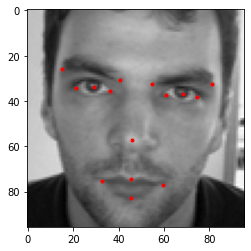

In [12]:
i = np.random.randint(1, len(facial_key_point_df))
plt.imshow(facial_key_point_df['Image'][i], cmap = 'gray')
for j in range(0, 30, 2):
        plt.plot(facial_key_point_df.loc[i][j], facial_key_point_df.loc[i][j+1], 'r.')

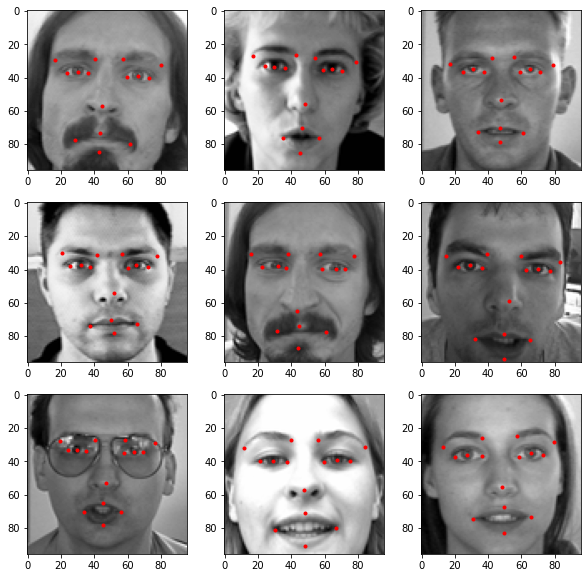

In [13]:
#viewing multiple images in grid format
fig = plt.figure(figsize=(10,10))

for i in range(9):
  fig.add_subplot(3, 3, i+1)
  plt.imshow(facial_key_point_df['Image'][i], cmap = 'gray')
  for j in range(0, 30, 2):
        plt.plot(facial_key_point_df.loc[i][j], facial_key_point_df.loc[i][j+1], 'r.')


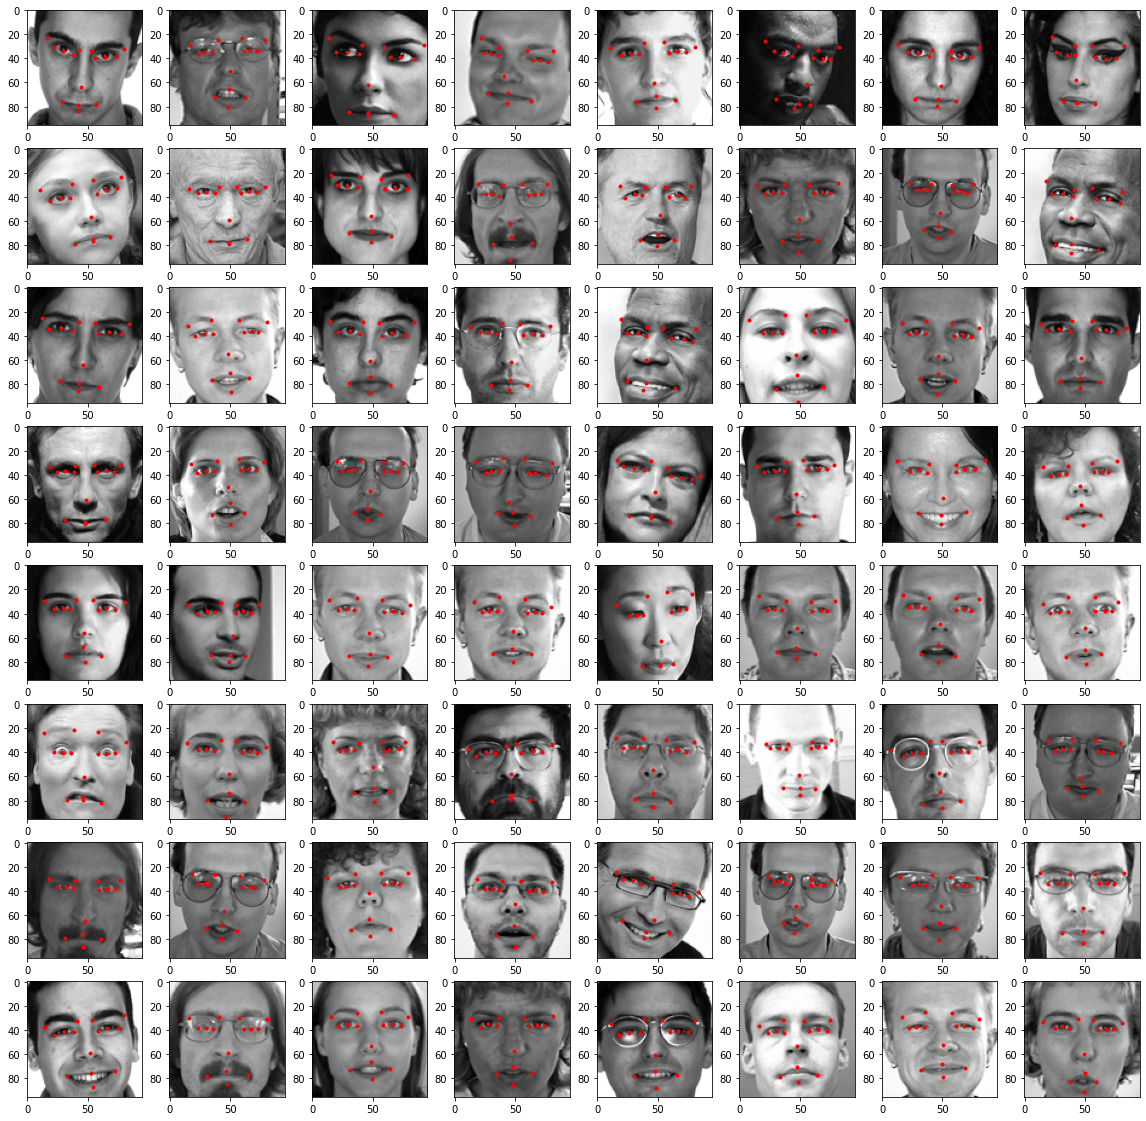

In [14]:
#sanity check
fig = plt.figure(figsize=(20,20))

for i in range(64):
  fig.add_subplot(8, 8, i+1)
  k = np.random.randint(1, len(facial_key_point_df))
  plt.imshow(facial_key_point_df['Image'][k], cmap = 'gray')
  for j in range(0, 30, 2):
        plt.plot(facial_key_point_df.loc[k][j], facial_key_point_df.loc[k][j+1], 'r.')


#e) Image Augmentation

In [15]:
columns = facial_key_point_df.columns[:-1] #except last one column
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

##Horizontal Flip

In [16]:
horizontal_flip_df = copy.copy(facial_key_point_df)
horizontal_flip_df['Image'] = horizontal_flip_df['Image'].apply(lambda x: np.flip(x, axis=1))

for i in range(len(columns)):
  if i%2 == 0:  #targeting x-coordinates
    horizontal_flip_df[columns[i]] = horizontal_flip_df[columns[i]].apply(lambda x: 96.0 - x)

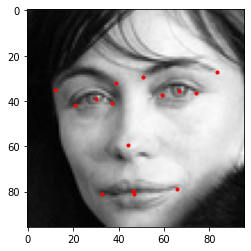

In [17]:
#Original Image
i = np.random.randint(1, len(facial_key_point_df))

plt.imshow(facial_key_point_df['Image'][i], cmap='gray')
for j in range(0,30,2):
  plt.plot(facial_key_point_df.loc[i][j], facial_key_point_df.loc[i][j+1], 'r.')

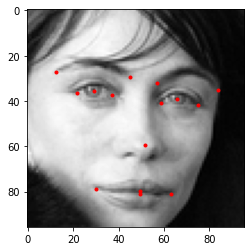

In [18]:
#Horizontally flipped image
plt.imshow(horizontal_flip_df['Image'][i], cmap='gray')
for j in range(0,30,2):
  plt.plot(horizontal_flip_df.loc[i][j], horizontal_flip_df.loc[i][j+1], 'r.')

##Vertical Flip

In [19]:
vertical_flip_df = copy.copy(facial_key_point_df)
vertical_flip_df['Image'] = vertical_flip_df['Image'].apply(lambda x: np.flip(x, axis=0))

for i in range(len(columns)):
  if i%2 != 0:  #targeting y-coordinates
    vertical_flip_df[columns[i]] = vertical_flip_df[columns[i]].apply(lambda x: 96.0 - x)

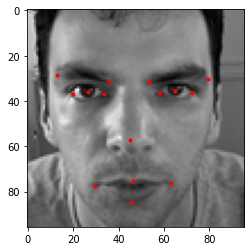

In [20]:
#Original Image
i = np.random.randint(1, len(facial_key_point_df))

plt.imshow(facial_key_point_df['Image'][i], cmap='gray')
for j in range(0,30,2):
  plt.plot(facial_key_point_df.loc[i][j], facial_key_point_df.loc[i][j+1], 'r.')

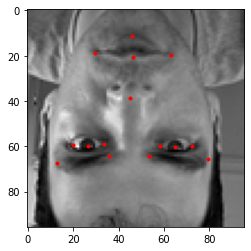

In [21]:
#Vertically flipped image
plt.imshow(vertical_flip_df['Image'][i], cmap='gray')
for j in range(0,30,2):
  plt.plot(vertical_flip_df.loc[i][j], vertical_flip_df.loc[i][j+1], 'r.')

##Increasing Brightness 

In [22]:
brightness_df = copy.copy(facial_key_point_df)
brightness_df['Image'] = brightness_df['Image'].apply(lambda x: np.clip(random.uniform(1.2, 1.8)* x, 0.0, 255.0))

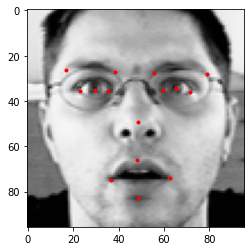

In [23]:
#Original Image
i = np.random.randint(1, len(facial_key_point_df))

plt.imshow(facial_key_point_df['Image'][i], cmap='gray')
for j in range(0,30,2):
  plt.plot(facial_key_point_df.loc[i][j], facial_key_point_df.loc[i][j+1], 'r.')

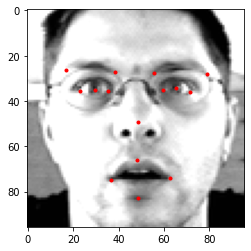

In [24]:
#Brightened Image
plt.imshow(brightness_df['Image'][i], cmap='gray')
for j in range(0,30,2):
  plt.plot(brightness_df.loc[i][j], brightness_df.loc[i][j+1], 'r.')

In [25]:
#concatenating the dataframes
augmented_df = pd.concat([facial_key_point_df, horizontal_flip_df, vertical_flip_df, brightness_df], ignore_index=True)
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          8560 non-null   float64
 1   left_eye_center_y          8560 non-null   float64
 2   right_eye_center_x         8560 non-null   float64
 3   right_eye_center_y         8560 non-null   float64
 4   left_eye_inner_corner_x    8560 non-null   float64
 5   left_eye_inner_corner_y    8560 non-null   float64
 6   left_eye_outer_corner_x    8560 non-null   float64
 7   left_eye_outer_corner_y    8560 non-null   float64
 8   right_eye_inner_corner_x   8560 non-null   float64
 9   right_eye_inner_corner_y   8560 non-null   float64
 10  right_eye_outer_corner_x   8560 non-null   float64
 11  right_eye_outer_corner_y   8560 non-null   float64
 12  left_eyebrow_inner_end_x   8560 non-null   float64
 13  left_eyebrow_inner_end_y   8560 non-null   float

#f) Data Normalization

In [26]:
img = augmented_df['Image']

#Normalizing Image
img = img/255.0
img.shape

(8560,)

#g) Data Preparation

In [27]:
#Expanding dimension
X = np.empty((len(img), 96, 96, 1))
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis=2)

#convert array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [28]:
#Obtaining value for Y
y = augmented_df.iloc[:,:30]
print(y.columns)
y = np.asarray(y).astype(np.float32)
y.shape

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


(8560, 30)

In [29]:
#Spliting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#h) Bulid Deep Residual Neural Network Model

In [30]:
def res_block(X, filter, stage):
  
  # Convolutional Block
  X_copy = X
  f1, f2, f3 = filter

  # main path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size=(3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size=(1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # add the path
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  # Identity Block 1
  X_copy = X

  # main path
  X = Conv2D(f1, kernel_size=(1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # add the path
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  # Identity Block 2
  X_copy = X

  # main path
  X = Conv2D(f1, kernel_size=(1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # add the path
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  return X

In [31]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero Padding
X = ZeroPadding2D((3,3))(X_input)

# Stage 1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage 2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage 3
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

#i) Train a model

In [32]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

In [33]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [34]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/2
204/204 [==============================] - ETA: 0s - loss: 356.7332 - accuracy: 0.5463
Epoch 00001: val_loss improved from inf to 669.28448, saving model to FacialKeyPoints_weights.hdf5
204/204 [==============================] - 13s 64ms/step - loss: 356.7332 - accuracy: 0.5463 - val_loss: 669.2845 - val_accuracy: 0.3994
Epoch 2/2
203/204 [============================>.] - ETA: 0s - loss: 124.4618 - accuracy: 0.6863
Epoch 00002: val_loss improved from 669.28448 to 198.89607, saving model to FacialKeyPoints_weights.hdf5
204/204 [==============================] - 11s 52ms/step - loss: 124.3682 - accuracy: 0.6864 - val_loss: 198.8961 - val_accuracy: 0.7259


In [35]:
# save the model in json file format
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)

#j) Evaluate the Model Performance

In [36]:
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [37]:
# Evaluate the model
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

54/54 [==============================] - 1s 18ms/step - loss: 185.9935 - accuracy: 0.7062
Accuracy : 0.7061915993690491


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

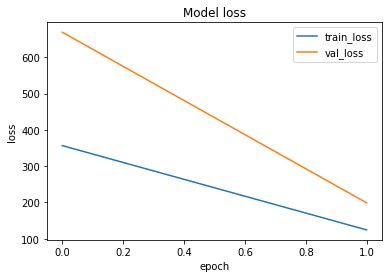

In [39]:
# Plot the training and validation losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

#FACIAL EMOTION PREDICTION

#a) Target Class Details

In [40]:
label_to_text = {0:'Angry', 1:'Disgust', 2:'sad', 3:'Happy', 4:'Surprise'}
for n, item in label_to_text.items():
  print(n,item)

0 Angry
1 Disgust
2 sad
3 Happy
4 Surprise


#b) Import and Explore the data

In [41]:
facial_expression_df = pd.read_csv('icml_face_data.csv')

In [42]:
facial_expression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [43]:
type(facial_expression_df['pixels'][0])

str

In [44]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48).astype('float32')

In [45]:
# Resize images from (48, 48) to (96, 96)

def resize(x):
  return cv2.resize(x, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [46]:
facial_expression_df['pixels'] = facial_expression_df['pixels'].apply(lambda x: string2array(x))
facial_expression_df['pixels'] = facial_expression_df['pixels'].apply(lambda x: resize(x))


In [47]:
facial_expression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [48]:
# check the shape of the data frame
facial_expression_df.shape

(24568, 2)

In [49]:
# check for the presence of null values in the data frame
facial_expression_df.isnull().sum()

emotion    0
pixels     0
dtype: int64

#c) Data Visualization

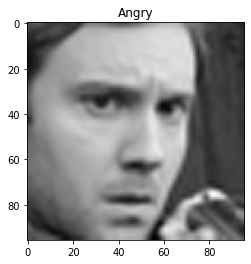

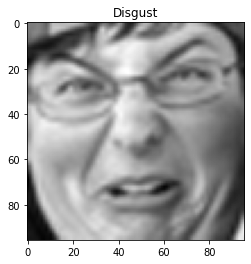

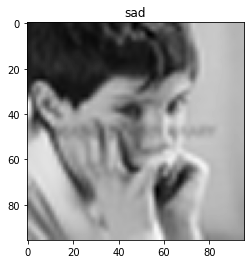

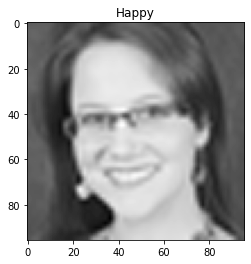

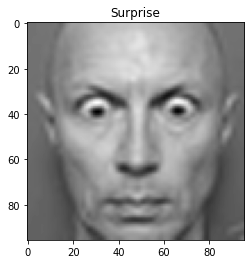

In [50]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facial_expression_df[facial_expression_df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [51]:
facial_expression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [52]:
facial_expression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

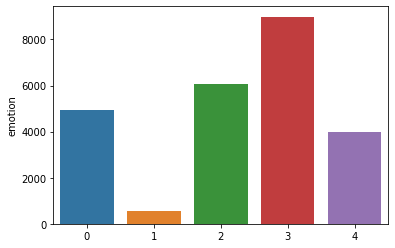

In [53]:
plt.figure()
sns.barplot(x=facial_expression_df.emotion.value_counts().index, y=facial_expression_df.emotion.value_counts())

#d) Data Normalization

In [54]:
X = facial_expression_df['pixels']
X = X/255.0

#e) Data Preparation

In [55]:
y = to_categorical(facial_expression_df['emotion'])

In [56]:
X = np.stack(X, axis = 0) 
X = X.reshape(24568, 96, 96, 1)

In [57]:
print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [58]:
# Split the dataframe into train, validation and test data
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.2, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

In [59]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_Test.shape, y_Test.shape)

(19654, 96, 96, 1) (19654, 5)
(2457, 96, 96, 1) (2457, 5)
(2457, 96, 96, 1) (2457, 5)


#f) Image Augmentation

In [60]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest")


#g) Build a model

In [61]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# zero padding
X = ZeroPadding2D((3, 3))(X_input)

# stage 1
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# stage 2
X = res_block(X, filter= [64, 64, 256], stage= 2)

# stage 3
X = res_block(X, filter= [128, 128, 512], stage= 3)

# stage 4
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

#h) Train the model

In [65]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [66]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 50, callbacks=[checkpointer, earlystopping])

Epoch 1/50
307/307 [==============================] - ETA: 0s - loss: 0.9894 - accuracy: 0.6012
Epoch 00001: val_loss improved from inf to 1.39601, saving model to FacialExpression_weights.hdf5
307/307 [==============================] - 31s 99ms/step - loss: 0.9894 - accuracy: 0.6012 - val_loss: 1.3960 - val_accuracy: 0.3394
Epoch 2/50
307/307 [==============================] - ETA: 0s - loss: 0.9084 - accuracy: 0.6388
Epoch 00002: val_loss improved from 1.39601 to 1.01995, saving model to FacialExpression_weights.hdf5
307/307 [==============================] - 30s 98ms/step - loss: 0.9084 - accuracy: 0.6388 - val_loss: 1.0199 - val_accuracy: 0.5800
Epoch 3/50
307/307 [==============================] - ETA: 0s - loss: 0.8401 - accuracy: 0.6720
Epoch 00003: val_loss improved from 1.01995 to 0.94089, saving model to FacialExpression_weights.hdf5
307/307 [==============================] - 30s 98ms/step - loss: 0.8401 - accuracy: 0.6720 - val_loss: 0.9409 - val_accuracy: 0.6398
Epoch 4/50


In [67]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

#i) Evaluate the model

In [68]:
with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [69]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

77/77 [==============================] - 1s 15ms/step - loss: 0.3465 - accuracy: 0.8738
Test Accuracy: 0.8738299012184143


In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

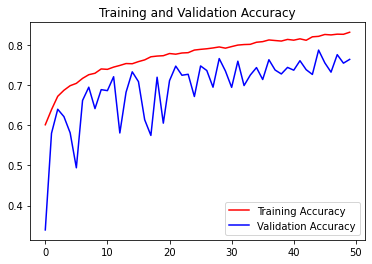

In [72]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy', color= 'r')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

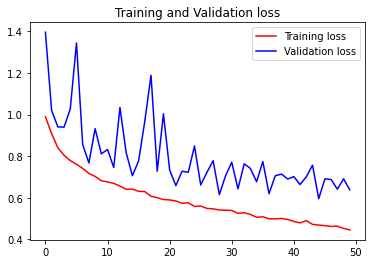

In [73]:
# loss

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [74]:
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

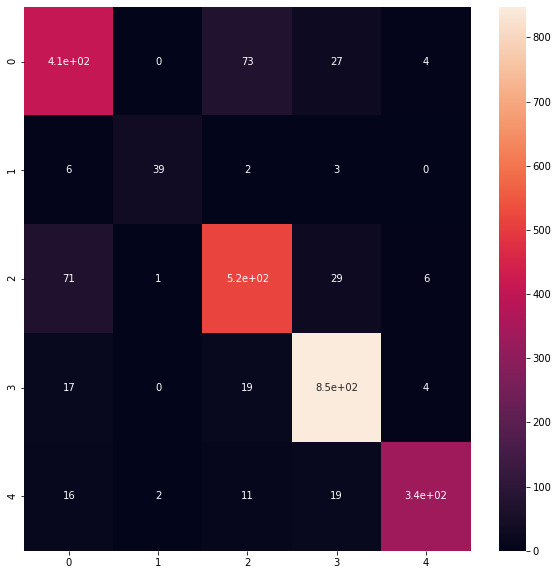

In [75]:
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = True)

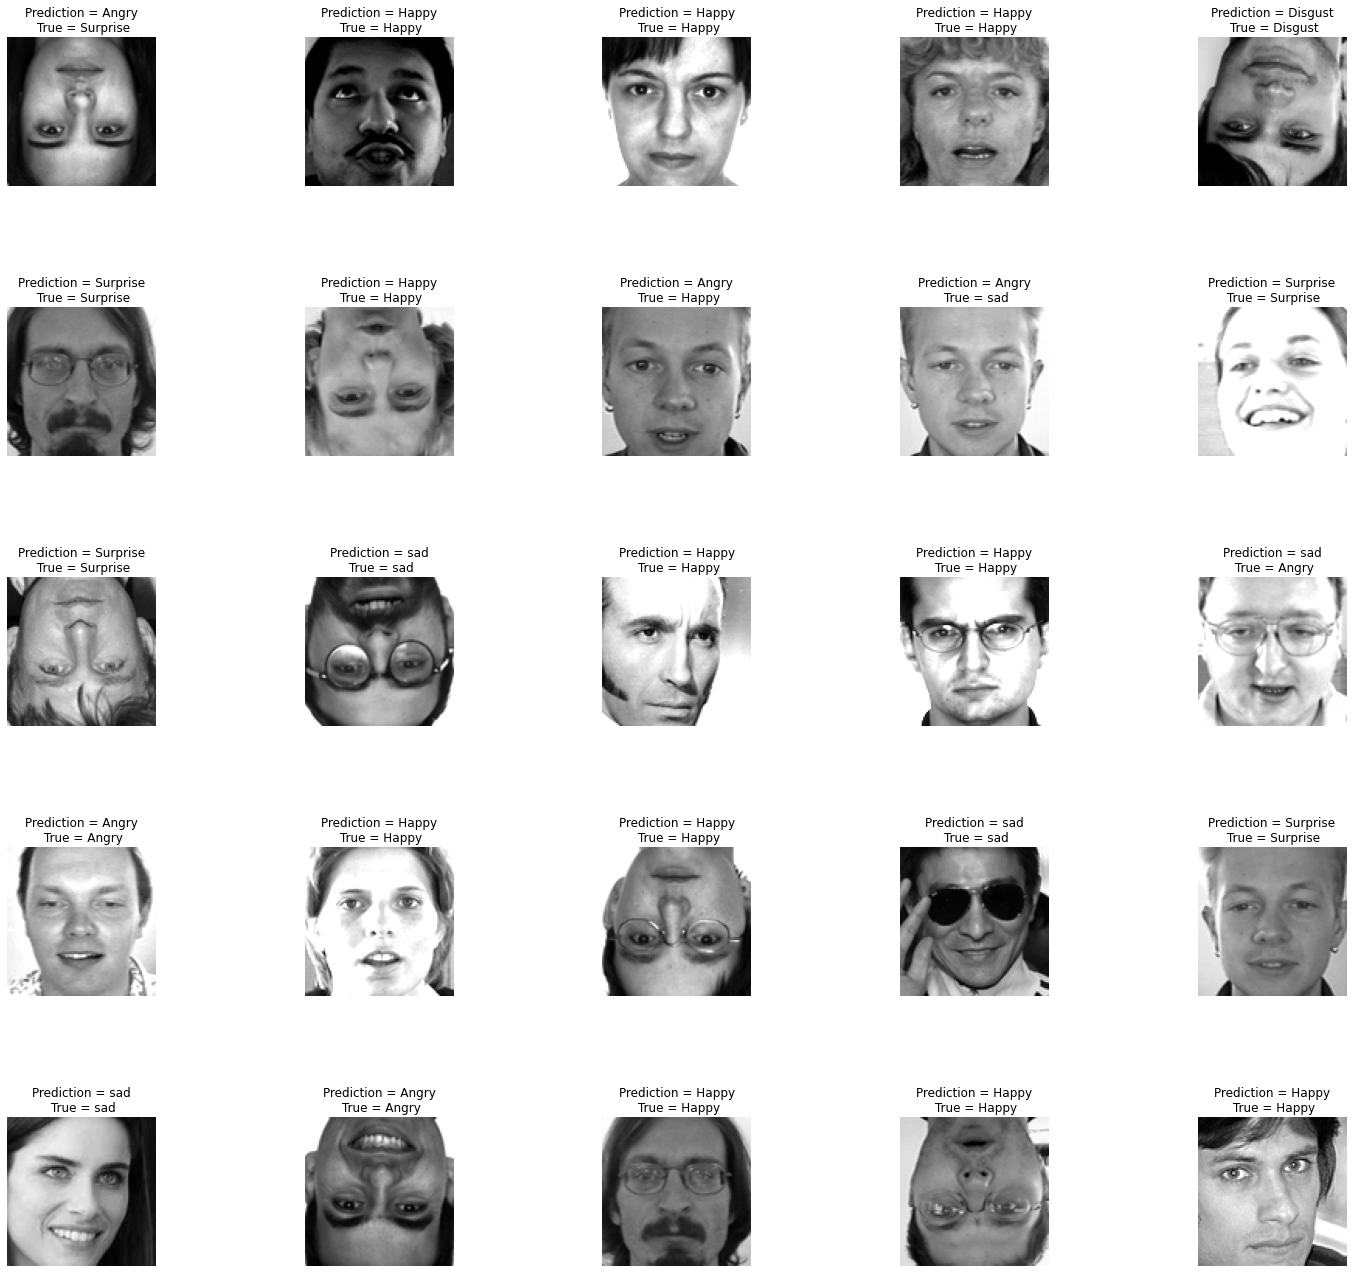

In [76]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   

In [77]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       511
           1       0.93      0.78      0.85        50
           2       0.83      0.83      0.83       626
           3       0.92      0.95      0.93       887
           4       0.96      0.87      0.92       383

    accuracy                           0.87      2457
   macro avg       0.88      0.85      0.86      2457
weighted avg       0.87      0.87      0.87      2457



#COMBINE THE MODELS

#a) Combining facial key points detection and facial emotion prediction

In [78]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (x,) to (x,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [79]:
df_predict = predict(X_test)

In [80]:
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,59.556999,32.451580,35.045208,34.104057,54.576279,33.267540,64.096107,32.394176,39.472015,33.802116,29.536175,35.216824,53.444180,22.155748,67.998741,23.508904,41.363235,22.874157,24.146416,28.250776,49.102764,52.449707,59.075867,65.542435,36.217587,67.403587,47.995453,65.441223,47.888142,73.287552,2
1,27.466732,36.803226,68.547806,38.284950,34.084641,37.359737,20.384989,37.845737,61.895119,38.281460,75.212990,39.764702,39.081303,24.367939,14.352956,27.491068,57.707596,25.833141,81.852478,31.089834,50.197712,54.342251,32.080406,78.650360,65.681328,79.057549,49.924328,70.274643,49.862259,88.332008,0
2,69.094376,36.039433,25.456327,34.439743,59.926731,36.949215,78.822601,36.836681,34.455830,35.543022,15.944530,34.683140,57.509724,28.592459,85.971649,25.810497,37.178288,27.948008,9.762807,24.707449,45.504734,62.421822,61.698261,79.203163,28.651350,77.495361,44.548672,76.196404,44.482185,86.926643,3
3,68.470810,36.363884,28.942480,35.834747,61.850327,36.813911,74.610428,37.428295,35.096149,36.200729,22.558554,36.829834,57.460262,28.410685,81.413185,29.149120,37.485786,28.066322,16.068348,28.749723,48.070179,52.014061,63.353249,75.927414,33.615963,75.710831,47.806087,68.657333,47.845032,86.034760,4
4,66.892212,35.179798,36.072403,34.887794,60.853077,35.674641,72.553314,35.999775,41.328075,35.267998,30.014151,35.785889,56.824253,25.867411,77.898964,29.438519,44.561867,26.149071,25.382982,29.284281,47.819271,51.649021,64.435417,70.222603,34.671928,70.322456,48.513744,66.543228,48.195908,80.011139,2


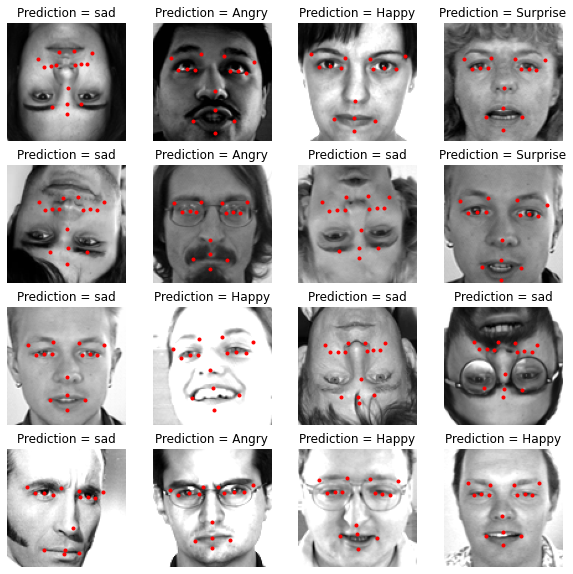

In [82]:
fig, axes = plt.subplots(4, 4, figsize = (10, 10))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(0,30,2):
            axes[i].plot(df_predict.loc[i][j], df_predict.loc[i][j+1], 'r.')

# DEPLOYMENT PHASE

#a) Deploy the model

In [91]:
# K_backend
def deploy(directory, model, version):
  # To deploy the model, we need directory and version of the model
  MODEL_DIR = directory

  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm' 

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

#b) Serve the model using Tensorflow 2.0 Serving

In [87]:
# Add tensorflow-model-server package
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   6643      0 --:--:-- --:--:-- --:--:--  6643
OK
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 htt

In [88]:
# Install tensorflow model server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 60 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 5s (45.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


In [92]:
deploy('/model_1', model_1_facialKeyPoints, version=1)

export_path = /model_1/1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /model_1/1/assets


In [93]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [94]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-08-31 19:01:38.493922: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-08-31 19:01:38.697241: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /model_1/1
2020-08-31 19:01:38.750388: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 344655 microseconds.
2020-08-31 19:01:38.760292: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model_1/1/assets.extra/tf_serving_warmup_requests
2020-08-31 19:01:38.760600: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: keypoint_model version: 1}
2020-08-31 19:01:38.762821: I tensorflow_serving/model_servers/server.cc:367] Running gRPC ModelServer at 0.0.0.0:85

In [95]:
deploy('/model_2', model_2_emotion, version=1)

export_path = /model_2/1

INFO:tensorflow:Assets written to: /model_2/1/assets


In [96]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [97]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-08-31 19:02:55.582460: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:199] Restoring SavedModel bundle.
2020-08-31 19:02:55.725064: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /model_2/1
2020-08-31 19:02:55.784744: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:303] SavedModel load for tags { serve }; Status: success: OK. Took 275488 microseconds.
2020-08-31 19:02:55.794378: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /model_2/1/assets.extra/tf_serving_warmup_requests
2020-08-31 19:02:55.794672: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: emotion_model version: 1}
2020-08-31 19:02:55.796712: I tensorflow_serving/model_servers/server.cc:367] Running gRPC ModelServer at 0.0.0.0:850

#c) Making a Request

In [98]:
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:10].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 1.0], [0.8854518532752991], [0.6048508882522583]]]]}


In [99]:
!pip install -q requests

In [101]:
# To make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)
  
  # Reshaping array from (x,) to (x,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [102]:
# making prediction
df_predict = response(data)

In [103]:
df_predict

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,59.556988,32.451595,35.045219,34.104061,54.576294,33.267540,64.096077,32.394180,39.472023,33.802124,29.536181,35.216827,53.444176,22.155748,67.998734,23.508911,41.363247,22.874161,24.146433,28.250784,49.102772,52.449703,59.075859,65.542435,36.217567,67.403600,47.995461,65.441246,47.888161,73.287506,2
1,27.466732,36.803230,68.547813,38.284958,34.084637,37.359737,20.384995,37.845753,61.895145,38.281456,75.212959,39.764700,39.081303,24.367931,14.352957,27.491074,57.707600,25.833145,81.852478,31.089827,50.197704,54.342255,32.080418,78.650368,65.681328,79.057564,49.924320,70.274635,49.862266,88.332008,0
2,69.094376,36.039432,25.456329,34.439751,59.926727,36.949215,78.822609,36.836693,34.455830,35.543022,15.944531,34.683136,57.509727,28.592470,85.971649,25.810497,37.178284,27.948000,9.762808,24.707443,45.504723,62.421837,61.698269,79.203171,28.651344,77.495369,44.548679,76.196426,44.482185,86.926643,3
3,68.470800,36.363880,28.942484,35.834751,61.850342,36.813919,74.610451,37.428280,35.096157,36.200733,22.558567,36.829822,57.460266,28.410683,81.413178,29.149124,37.485775,28.066319,16.068352,28.749718,48.070160,52.014061,63.353237,75.927414,33.615967,75.710815,47.806091,68.657300,47.845016,86.034760,4
4,66.892204,35.179794,36.072403,34.887794,60.853065,35.674637,72.553307,35.999764,41.328060,35.267998,30.014154,35.785885,56.824261,25.867414,77.898972,29.438515,44.561863,26.149061,25.382992,29.284275,47.819271,51.649029,64.435417,70.222611,34.671932,70.322441,48.513733,66.543228,48.195915,80.011116,2
5,64.591682,37.694439,29.396868,37.123291,58.916683,38.189136,70.183426,38.131661,34.516361,37.569557,23.446533,37.589073,55.725400,29.984552,76.291679,29.482536,38.362846,29.788034,16.386341,30.004932,46.261444,60.544407,60.138073,76.538437,31.784832,76.113716,45.687664,71.685852,45.590645,83.694771,0
6,63.089466,34.616493,31.173307,36.088528,56.965416,35.458031,68.841331,34.726383,37.037148,36.059800,24.554081,37.137104,56.065414,25.033007,72.845383,25.223238,38.460442,25.646900,18.903980,29.280804,50.047836,52.173700,63.820087,67.250687,32.514351,69.007774,48.630627,66.763191,48.730297,75.429642,2
7,68.513313,39.655067,26.530945,37.642265,60.979210,39.795479,75.645393,41.005772,33.447021,38.065380,19.123924,38.445389,58.998405,27.916098,82.888107,31.725559,35.437378,26.125774,12.200517,28.776516,46.339645,60.076969,62.391487,82.896217,30.088039,82.142891,46.189030,76.770508,46.004532,93.306800,4
8,66.812752,37.999344,29.499931,37.487080,60.058594,38.360352,72.765869,38.964783,35.646618,37.734070,22.950400,38.470314,57.751019,28.653290,78.516449,30.816044,36.672894,27.918341,16.710129,30.804733,48.213581,56.612240,62.585857,75.192573,34.109028,75.285767,48.346321,71.435081,48.419289,83.640907,2
9,67.286600,36.207363,29.499600,38.943287,60.012722,37.039116,75.192566,37.236027,36.520800,38.735447,22.138600,41.010345,55.824966,23.814047,80.977867,28.365206,37.069588,26.016739,15.740889,33.554771,45.591385,50.742706,69.285800,71.256424,31.190226,73.578804,48.144062,65.481155,49.160011,82.978760,3


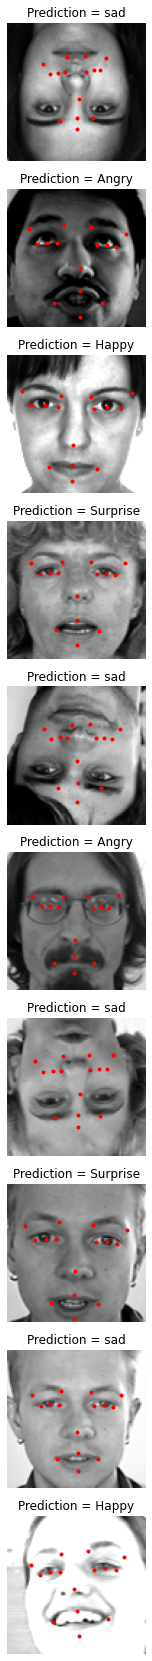

In [109]:
# Plotting the images and their predicted keypoints with their emotions

fig, axes = plt.subplots(10, 1, figsize = (30, 30))
axes = axes.ravel()

for i in range(10):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(0,30,2):
            axes[i].plot(df_predict.loc[i][j], df_predict.loc[i][j+1], 'r.')